In [1]:
import keras
import csv
import os
import itertools
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.layers import *
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
TRAIN_DIR = os.path.join(ROOT_DIR, 'data', 'train')
TEST_DIR =  os.path.join(ROOT_DIR, 'data', 'validation')

In [4]:
img_width, img_height = 300, 300

In [5]:
batch_size = 32
epoch = 5
drop_prob = 0.6
out_class = 13

In [6]:
train_gen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.2, horizontal_flip = True, vertical_flip = True)

In [7]:
test_gen = ImageDataGenerator(rescale=1. / 255)

In [8]:
train_generator = train_gen.flow_from_directory(TRAIN_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 152397 images belonging to 13 classes.


In [9]:
'''val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')'''

"val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), \n                                                batch_size=batch_size, class_mode='categorical')"

In [10]:
test_generator = test_gen.flow_from_directory(TEST_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 55388 images belonging to 13 classes.


In [11]:
input_ = Input(shape=(img_width, img_height, 3))

with tf.device('/gpu:1'):
    transfer_model = InceptionV3(input_tensor = input_, weights = 'imagenet', include_top = False)

In [12]:
x = transfer_model.output

x = MaxPooling2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)

x = Dropout(drop_prob)(x)

out = Dense(out_class, activation = 'softmax')(x)

In [13]:
model = Model(inputs = transfer_model.input, outputs = out)

In [14]:
adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [15]:
for layer in transfer_model.layers:
    layer.trainable = False

In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_, metrics = ['accuracy'])

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [18]:
#tensorboard = TensorBoardColabCallback(TensorBoardColab()) #Using Tensorboard on google colab

In [19]:
checkpointer = ModelCheckpoint(filepath='checkpoint_inception.h5', save_best_only=True)

In [20]:
callback_list = [checkpointer]

In [21]:
with tf.device('/gpu:1'):
    history = model.fit_generator(train_generator, steps_per_epoch = int(152397/batch_size), epochs = epoch, shuffle = True, 
                    callbacks = callback_list)

Epoch 1/5
4762/4762 [==============================] - 2016s 423ms/step - loss: 0.6282 - acc: 0.8202
Epoch 2/5


/home/aumkar/anaconda3/envs/daenv/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


4762/4762 [==============================] - 1987s 417ms/step - loss: 0.4173 - acc: 0.8835
Epoch 3/5
4762/4762 [==============================] - 1985s 417ms/step - loss: 0.3956 - acc: 0.8942
Epoch 4/5
4762/4762 [==============================] - 1995s 419ms/step - loss: 0.3895 - acc: 0.8985
Epoch 5/5
4762/4762 [==============================] - 1994s 419ms/step - loss: 0.3943 - acc: 0.9029


In [30]:
Y_pred = model.predict_generator(test_generator, int(55388/batch_size+1))
y_pred = np.argmax(Y_pred, axis=1)

In [31]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, int(795/batch_size+1))

In [32]:
test_loss

3.7340503120422364

In [33]:
test_accuracy

0.50125

In [ ]:
model_check = load_model('checkpoint_inception.h5')

In [40]:
#test_check_loss, test_check_acc = model_check.evaluate_generator(test_generator, int(795/batch_size+1))

In [ ]:
test_check_loss

In [ ]:
test_check_acc

In [34]:
target_names = ['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 
                'skateboard', 'train', 'truck']

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()

In [36]:
cnf = confusion_matrix(test_generator.classes, y_pred)

Confusion matrix
[[ 292   29  563  429  166   63  659   21  160  149  872  243]
 [ 240   39  539  444  172   70  654   14  160  113  771  259]
 [ 356   44  723  547  200  104  831   30  209  177 1127  342]
 [ 803  112 1521 1234  504  225 1833   68  472  413 2547  669]
 [ 371   37  715  521  250  101  870   18  215  150 1141  302]
 [ 164   21  328  224   82   55  355   12   97   85  532  120]
 [ 424   76  878  694  264  129 1041   34  247  178 1416  415]
 [ 316   43  580  511  195   81  664   24  197  156  928  305]
 [ 340   37  679  496  226   94  781   28  216  191 1118  343]
 [ 154   20  335  303  103   63  394   15   95   93  547  159]
 [ 329   32  572  513  218   88  779   26  184  162 1032  301]
 [ 405   58  808  686  253  122  998   33  257  205 1307  416]]


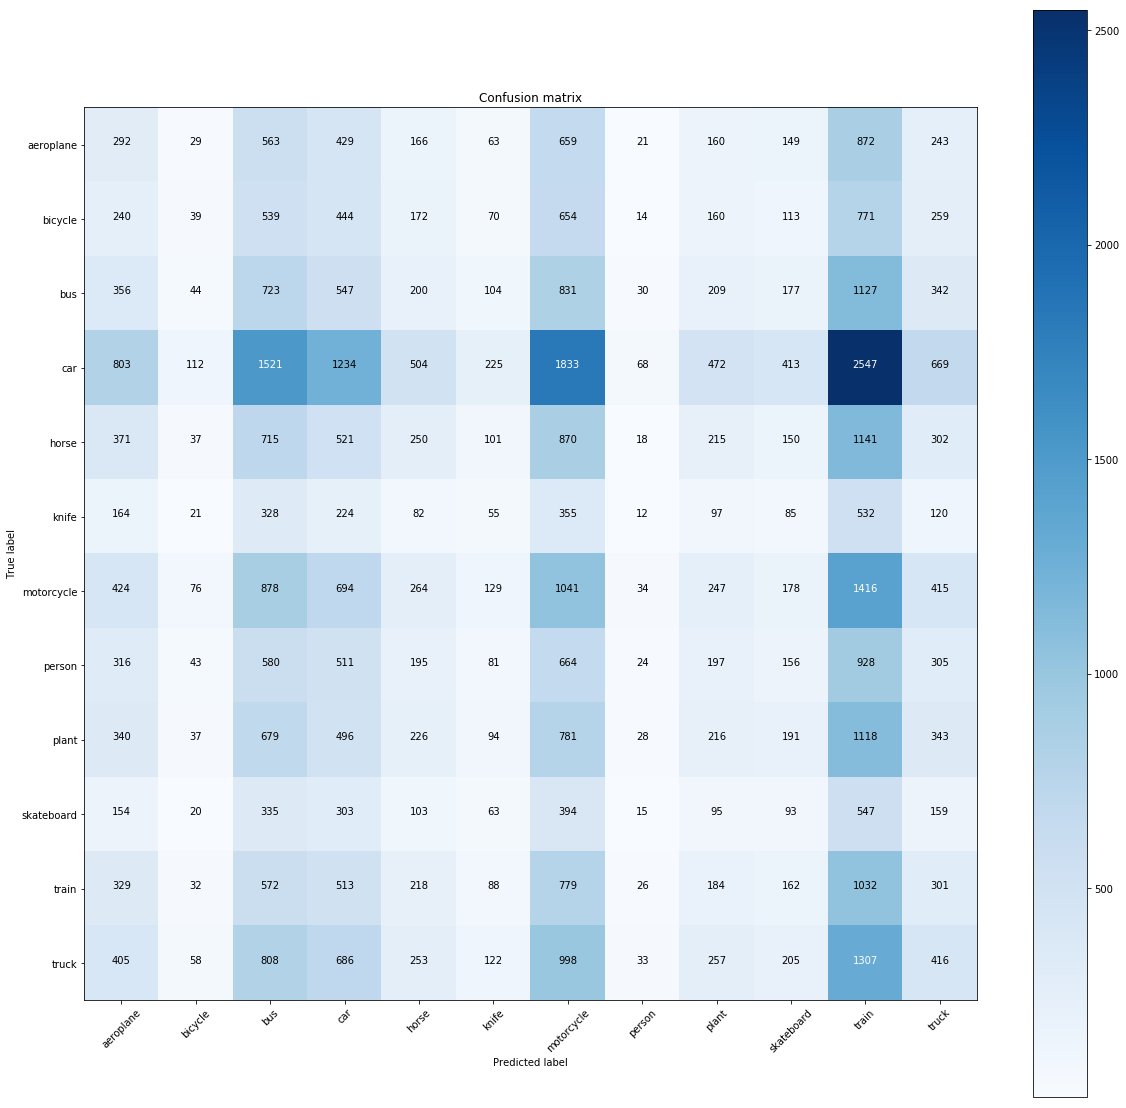

In [37]:
plot_confusion_matrix(cnf, classes=target_names, title='Confusion matrix')

In [38]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   aeroplane       0.07      0.08      0.07      3646
     bicycle       0.07      0.01      0.02      3475
         bus       0.09      0.15      0.11      4690
         car       0.19      0.12      0.15     10401
       horse       0.09      0.05      0.07      4691
       knife       0.05      0.03      0.03      2075
  motorcycle       0.11      0.18      0.13      5796
      person       0.07      0.01      0.01      4000
       plant       0.09      0.05      0.06      4549
  skateboard       0.04      0.04      0.04      2281
       train       0.08      0.24      0.12      4236
       truck       0.11      0.07      0.09      5548

   micro avg       0.10      0.10      0.10     55388
   macro avg       0.09      0.09      0.08     55388
weighted avg       0.10      0.10      0.09     55388



In [39]:
model.save('inceptionV3.h5')